In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
import glob
import gc

In [2]:
# set base path to the directory containing the csv files of the dataset
dataset_base_path_parquet = r'D:/GIU/Semester 7/Bachelor Thesis/Datasets/CICIDS 2018/full cicids 2018/processed/newPARQUET'

In [3]:
parquet_files = glob.glob(os.path.join(dataset_base_path_parquet, '*.parquet'))

network_data = pd.concat((pd.read_parquet(f) for f in parquet_files))

In [4]:
network_data.shape

(15738470, 80)

In [5]:
network_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15738470 entries, 0 to 601380
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   dst_port           uint32 
 1   protocol           uint8  
 2   timestamp          object 
 3   flow_duration      int64  
 4   tot_fwd_pkts       uint32 
 5   tot_bwd_pkts       uint32 
 6   totlen_fwd_pkts    uint32 
 7   totlen_bwd_pkts    uint32 
 8   fwd_pkt_len_max    uint16 
 9   fwd_pkt_len_min    uint16 
 10  fwd_pkt_len_mean   float32
 11  fwd_pkt_len_std    float32
 12  bwd_pkt_len_max    uint16 
 13  bwd_pkt_len_min    uint16 
 14  bwd_pkt_len_mean   float32
 15  bwd_pkt_len_std    float32
 16  flow_byts_s        float64
 17  flow_pkts_s        float64
 18  flow_iat_mean      float32
 19  flow_iat_std       float32
 20  flow_iat_max       int64  
 21  flow_iat_min       int64  
 22  fwd_iat_tot        int64  
 23  fwd_iat_mean       float32
 24  fwd_iat_std        float32
 25  fwd_iat_max       

In [6]:
def change_label(df):
    df.label.replace(['Infilteration', 'Bot', 'FTP-BruteForce',
       'SSH-Bruteforce', 'DoS attacks-GoldenEye', 'DoS attacks-Slowloris',
       'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk',
       'DDoS attacks-LOIC-HTTP', 'DDOS attack-LOIC-UDP',
       'DDOS attack-HOIC', 'Brute Force -Web', 'Brute Force -XSS',
       'SQL Injection'],'Malicious',inplace=True)


In [7]:
change_label(network_data)

In [8]:
# check the number of values for labels
network_data['label'].value_counts()

Benign       13385066
Malicious     2353404
Name: label, dtype: int64

In [9]:
label_encoder = LabelEncoder()
network_data['label']= label_encoder.fit_transform(network_data['label'])
network_data['label'].unique()

array([0, 1])

In [10]:
# check for encoded labels
network_data['label'].value_counts()

0    13385066
1     2353404
Name: label, dtype: int64

In [11]:
network_data.shape

(15738470, 80)

In [12]:
network_data.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split


training_data, testing_data = train_test_split(network_data, test_size=0.2, random_state=132, stratify=network_data.label)

In [14]:
target_train = training_data['label']
target_test = testing_data['label']
target_train.unique(), target_test.unique()

(array([0, 1]), array([0, 1]))

In [15]:
training_data.drop(columns = ["timestamp","label"], axis=1, inplace = True)
testing_data.drop(columns = ["timestamp","label"], axis=1, inplace = True)

In [16]:
print(training_data.shape)
print(testing_data.shape)
print(target_train.shape)
print(target_test.shape)

(12590776, 78)
(3147694, 78)
(12590776,)
(3147694,)


In [17]:
y_train = to_categorical(target_train, num_classes=2)
y_test = to_categorical(target_test, num_classes=2)

In [18]:
# %%time
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel

# sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
# sel.fit(X_train, y_train)

In [19]:
# selected_feat = X_train.columns[(sel.get_support())]
# print(selected_feat)

In [20]:
# len(selected_feat)

In [22]:
selected_feat = ['bwd_header_len', 'bwd_pkt_len_mean','bwd_pkt_len_std', 
       'dst_port', 'flow_duration', 'flow_iat_max','flow_iat_mean', 
       'flow_iat_min', 'flow_pkts_s', 'fwd_header_len',
       'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_tot',
       'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'fwd_pkts_s',
       'fwd_seg_size_avg', 'fwd_seg_size_min', 'init_fwd_win_byts',
       'pkt_size_avg', 'subflow_fwd_byts', 'totlen_fwd_pkts', 'tot_bwd_pkts']

In [23]:
X_train = training_data[selected_feat]
X_train.shape

(12590776, 25)

In [24]:
X_test = testing_data[selected_feat]
X_test.shape

(3147694, 25)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12590776, 25)
(3147694, 25)
(12590776, 2)
(3147694, 2)


In [26]:
del network_data
gc.collect()

57

In [27]:
del training_data,testing_data,target_train,target_test

In [28]:
gc.collect()

0

# XGBoost (XGB-2C)

In [29]:
from xgboost import XGBClassifier

In [59]:
%%time
# Import the necessary libraries
from xgboost import XGBClassifier


# model3 = XGBClassifier(n_estimators = 1900,
#                         max_depth = 10,
#                         reg_lambda = 4.8139,
#                         min_samples_split = 254,
#                         random_state = 5, tree_method = 'hist',n_jobs = -1)

# model3.fit(X_train, y_train)

[18:48:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

Wall time: 58min 48s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              min_samples_split=254, missing=nan, monotone_constraints='()',
              n_estimators=1900, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', ...)

In [60]:
# import pickle

# with open('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/XGB_V5.3.2.pkl','wb') as file:
#     pickle.dump(model3,file)

In [30]:
import pickle

with open('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/XGB_V5.3.2.pkl','rb') as f:
    model3 = pickle.load(f)

In [31]:
%%time
Y_test_pred3 = model3.predict(X_test)

Wall time: 1min 6s


In [32]:
test_accuracy = model3.score(X_test,y_test)
print("Test score is:",test_accuracy)

Test score is: 0.9903627862174659


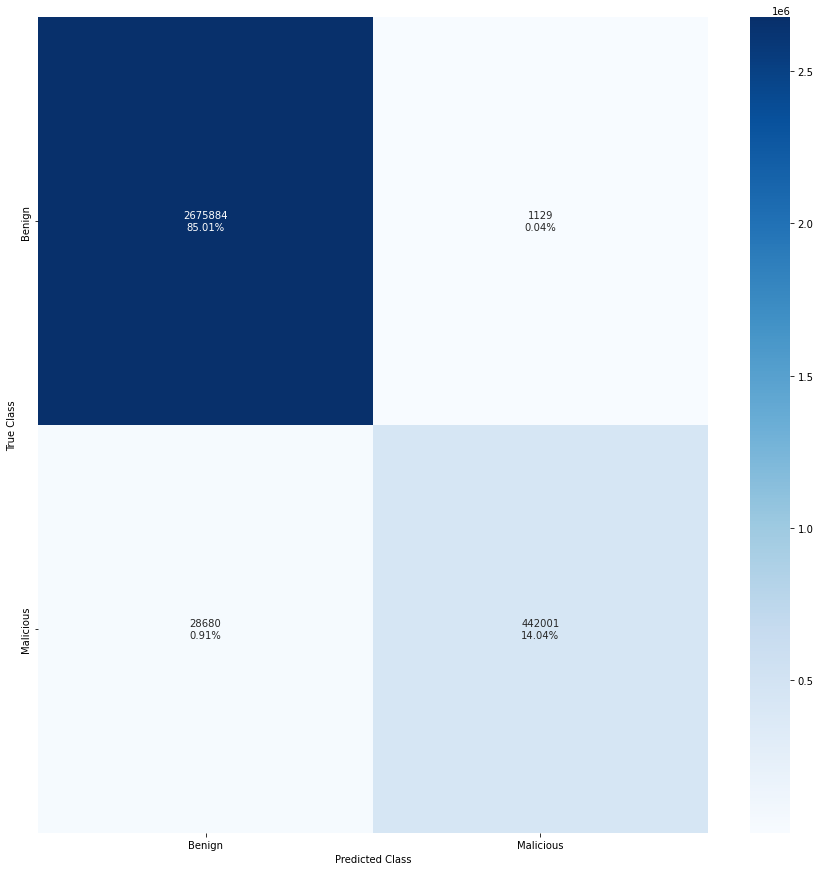

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
import tensorflow as tf 
#model = tf.keras.models.load_model('/'+model_name+'.h5')

y_pred = model3.predict(X_test)

y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_cm, y_pred_cm) 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

label = ['Benign','Malicious']

plt.figure(figsize=(15,15))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
# plt.title('Confusion Matrix for'+ modelName+' model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
# plt.savefig('./'+modelName+'_CM.png')
plt.show()

In [34]:
from sklearn.metrics import classification_report



print(classification_report(y_test_cm, y_pred_cm, target_names= label,digits=5))
                            
# accuracy = model3.score(X_test,y_test)
accuracy = test_accuracy
print("Test: accuracy = %f  " % (accuracy))

              precision    recall  f1-score   support

      Benign    0.98940   0.99958   0.99446   2677013
   Malicious    0.99745   0.93907   0.96738    470681

    accuracy                        0.99053   3147694
   macro avg    0.99342   0.96932   0.98092   3147694
weighted avg    0.99060   0.99053   0.99041   3147694

Test: accuracy = 0.990363  


# Random Forest (RF-2C)

In [60]:
# %%time
# #RANDOM FOREST
# model3 = RandomForestClassifier(n_estimators=150,n_jobs=-1 )
# model3.fit(X_train, y_train)

Wall time: 1h 52min 9s


RandomForestClassifier(n_estimators=150, n_jobs=-1)

In [ ]:
# import pickle

# with open('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/RF_V5.3.2.pkl','wb') as file:
#     pickle.dump(model3,file)

In [ ]:
import pickle

with open('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/RF_V5.3.2.pkl','rb') as f:
    model3 = pickle.load(f)

In [27]:
%%time
Y_test_pred3 = model3.predict(X_test)

Wall time: 1min 4s


In [28]:
test_accuracy = model3.score(X_test,y_test)
print("Test score is:",test_accuracy)

Test score is: 0.9933220954768792


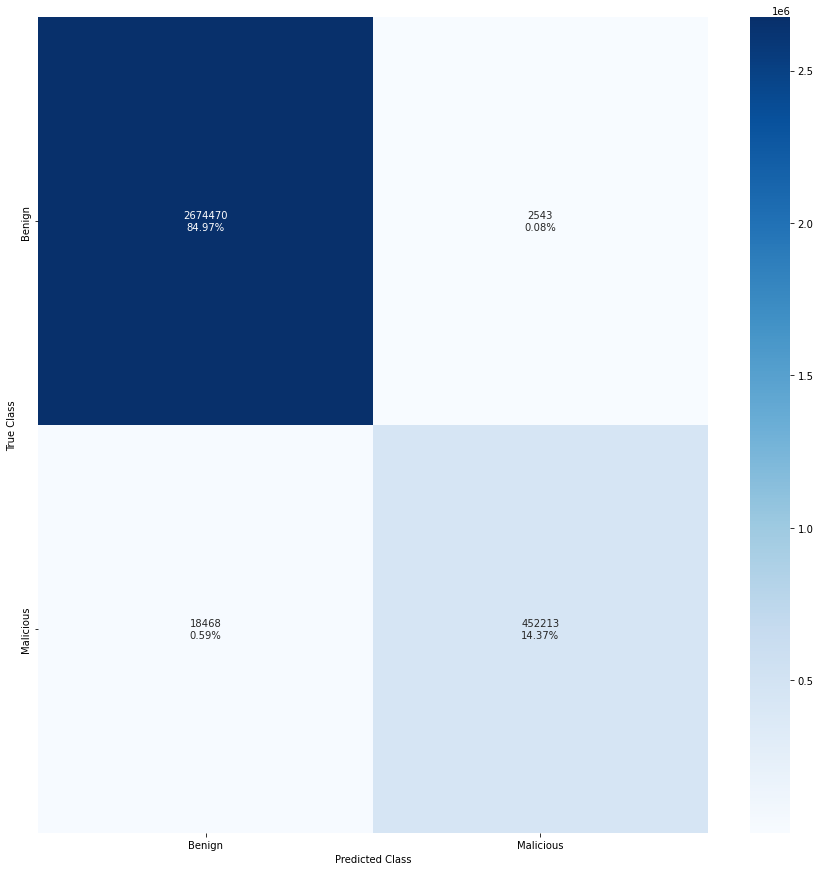

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
import tensorflow as tf 
#model = tf.keras.models.load_model('/'+model_name+'.h5')

y_pred = Y_test_pred3

y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_cm, y_pred_cm) 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

label = ['Benign','Malicious']

plt.figure(figsize=(15,15))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
# plt.title('Confusion Matrix for'+ modelName+' model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
# plt.savefig('./'+modelName+'_CM.png')
plt.show()

In [30]:
from sklearn.metrics import classification_report



print(classification_report(y_test_cm, y_pred_cm, target_names= label,digits=5))
                            
# accuracy = model3.score(X_test,y_test)
accuracy = test_accuracy
print("Test: accuracy = %f  " % (accuracy))

              precision    recall  f1-score   support

      Benign    0.99314   0.99905   0.99609   2677013
   Malicious    0.99441   0.96076   0.97730    470681

    accuracy                        0.99332   3147694
   macro avg    0.99378   0.97991   0.98669   3147694
weighted avg    0.99333   0.99332   0.99328   3147694

Test: accuracy = 0.993322  


# CNN (CNN-2C)

In [117]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

scalar1 = scaler.fit_transform(X_train)
scalar2 = scaler.fit_transform(X_test)

X_train = pd.DataFrame(scalar1)
X_test = pd.DataFrame(scalar2)

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.035647,1.899609,2.405804,-0.463829,0.099503,0.081653,-0.002948,-0.003703,-0.151444,-0.002324,...,0.024371,0.034152,-0.135099,0.024371,0.348355,-0.021717,1.452191,-0.007664,-0.007664,0.034024
1,-0.039650,-0.324565,-0.658880,-0.484394,-0.026014,-0.010581,-0.013528,-0.003702,-0.143237,-0.020539,...,-0.277977,-0.621483,-0.130685,-0.277977,-1.330477,-0.525638,-0.237796,-0.018453,-0.018453,-0.033695
2,0.088726,-0.311593,0.524473,-0.482970,0.220465,0.005234,0.002235,-0.003703,-0.151445,0.005808,...,-0.381909,0.329408,-0.135099,-0.381909,0.348355,-0.021717,-0.429268,-0.010166,-0.010166,0.046337
3,-0.042119,-0.705939,-0.658880,-0.482970,0.040305,0.038536,0.109398,0.042106,-0.151446,-0.017937,...,-0.854233,-0.621483,-0.135100,-0.854233,0.348355,-0.399550,-0.849953,-0.019137,-0.019137,-0.039852
4,-0.013728,0.709078,1.610802,-0.482970,-0.025974,-0.010561,-0.013519,-0.003703,-0.149826,-0.015335,...,0.847096,0.900542,-0.134353,0.847096,0.348355,3.505238,0.787288,-0.013078,-0.013078,-0.015226


In [118]:
# reshape the data for CNN
X_train = X_train.values
X_test = X_test.values


X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((12590776, 25, 1), (3147694, 25, 1))

In [ ]:
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [ ]:
from keras.layers import Dense, Dropout, Activation, Lambda

# making the deep learning function
def model():
    model = Sequential()
    model.add(Conv1D(32,3,activation='relu',padding='same',kernel_initializer='he_uniform',input_shape=(X_train.shape[1], 1)))
    model.add(Conv1D(32,3,activation='relu',padding='same',kernel_initializer='he_uniform'))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Conv1D(64,3,activation='relu',padding='same',kernel_initializer='he_uniform'))
    model.add(Conv1D(64,3,activation='relu',padding='same',kernel_initializer='he_uniform')) 
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())    

    model.add(Flatten())
    model.add(Dense(32,activation='relu'))
    model.add(Dense(2,activation='softmax'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [47]:
model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 32)            0         
                                                                 
 batch_normalization (BatchN  (None, 12, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 64)            6

In [39]:
batch_size = 4096
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_train, y_train, epochs=25#
                , batch_size=batch_size, 
          validation_data=(X_test, y_test), callbacks=[logger])

Epoch 1/25
3074/3074 [==============================] - 634s 205ms/step - loss: 0.0620 - accuracy: 0.9853 - val_loss: 0.0873 - val_accuracy: 0.9742
Epoch 2/25
3074/3074 [==============================] - 643s 209ms/step - loss: 0.0528 - accuracy: 0.9883 - val_loss: 0.0761 - val_accuracy: 0.9713
Epoch 3/25
3074/3074 [==============================] - 640s 208ms/step - loss: 0.0508 - accuracy: 0.9888 - val_loss: 0.0898 - val_accuracy: 0.9756
Epoch 4/25
3074/3074 [==============================] - 618s 201ms/step - loss: 0.0504 - accuracy: 0.9889 - val_loss: 0.1215 - val_accuracy: 0.9720
Epoch 5/25
3074/3074 [==============================] - 619s 201ms/step - loss: 0.0500 - accuracy: 0.9891 - val_loss: 0.1027 - val_accuracy: 0.9733
Epoch 6/25
3074/3074 [==============================] - 618s 201ms/step - loss: 0.0501 - accuracy: 0.9889 - val_loss: 0.1156 - val_accuracy: 0.9756
Epoch 7/25
3074/3074 [==============================] - 615s 200ms/step - loss: 0.0495 - accuracy: 0.9891 - val_

In [ ]:
model.save("D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/CNN_V5.3.2.h5")

In [ ]:
from keras.models import load_model


loaded_model = load_model('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/CNN_V5.3.2.h5')

98366/98366 [==============================] - 176s 2ms/step


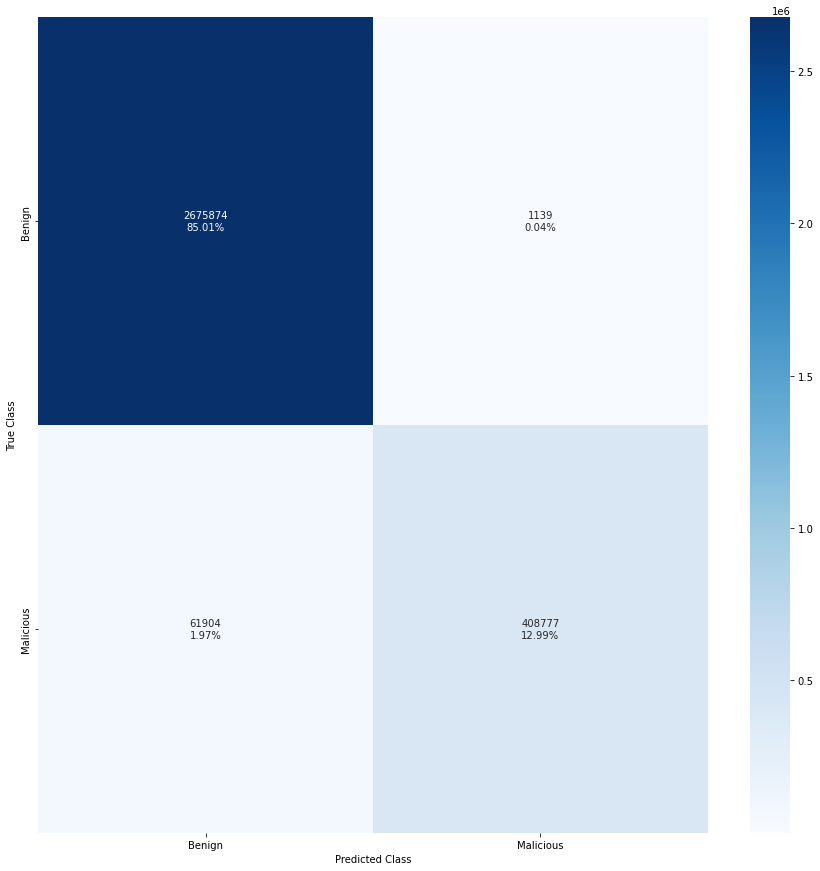

In [120]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
import tensorflow as tf 
#model = tf.keras.models.load_model('/'+model_name+'.h5')

y_pred = model.predict(X_test)

y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_cm, y_pred_cm) 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

label = ['Benign','Malicious']

plt.figure(figsize=(15,15))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
# plt.title('Confusion Matrix for'+ modelName+' model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
# plt.savefig('./'+modelName+'_CM.png')
plt.show()

In [121]:
from sklearn.metrics import classification_report



print(classification_report(y_test_cm, y_pred_cm, target_names= label,digits=5))
                            
loss, accuracy = model.evaluate(X_test,y_test, verbose = 1)
print("Test: accuracy = %f ; loss = %f " % (accuracy,loss))

              precision    recall  f1-score   support

      Benign    0.97739   0.99957   0.98836   2677013
   Malicious    0.99722   0.86848   0.92841    470681

    accuracy                        0.97997   3147694
   macro avg    0.98731   0.93403   0.95838   3147694
weighted avg    0.98035   0.97997   0.97939   3147694

98366/98366 [==============================] - 218s 2ms/step - loss: 0.0711 - accuracy: 0.9800
Test: accuracy = 0.979972 ; loss = 0.071137 


# DNN (DNN-2C)

In [102]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

scalar1 = scaler.fit_transform(X_train)
scalar2 = scaler.fit_transform(X_test)

X_train = pd.DataFrame(scalar1)
X_test = pd.DataFrame(scalar2)

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.039927,-0.335890,-0.658289,-0.484346,-0.022807,-0.010610,-0.013517,-0.003370,-0.122502,-0.020591,...,-0.112834,-0.621084,-0.119523,-0.112834,-1.330416,-0.525644,-0.154665,-0.018309,-0.018309,-0.033944
1,-0.036206,-0.704269,-0.658289,-0.486033,-0.022808,-0.010611,-0.013518,-0.003371,0.289464,-0.018028,...,-0.851332,-0.621084,0.102121,-0.851332,3.146360,1.128216,-0.848340,-0.019171,-0.019171,-0.033944
2,-0.039927,0.026450,-0.658289,-0.484346,-0.022806,-0.010609,-0.013514,-0.003369,-0.142327,-0.020591,...,-0.244122,-0.621084,-0.130189,-0.244122,-1.330416,-0.525644,0.047465,-0.018462,-0.018462,-0.033944
3,-0.042407,-0.704269,-0.658289,-0.487141,0.188516,0.078170,0.209088,0.074410,-0.151533,-0.021232,...,-0.851332,-0.621084,-0.135142,-0.851332,-2.449610,-0.525644,-0.848340,-0.019171,-0.019171,-0.040131
4,-0.013884,0.032489,0.525267,-0.482922,-0.022806,-0.010610,-0.013517,-0.003371,-0.122696,-0.015464,...,0.029395,0.169050,-0.121844,0.029395,0.348375,-0.021624,0.003495,-0.016087,-0.016087,-0.015385


In [ ]:
import tensorflow as tf

def model():

    # Define the model
    model = tf.keras.Sequential()

    # Add the layers
    model.add(tf.keras.layers.Dense(300, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))

    
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00061)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model



In [59]:
model = model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 300)               7800      
                                                                 
 dropout_17 (Dropout)        (None, 300)               0         
                                                                 
 dense_21 (Dense)            (None, 300)               90300     
                                                                 
 dropout_18 (Dropout)        (None, 300)               0         
                                                                 
 dense_22 (Dense)            (None, 300)               90300     
                                                                 
 dropout_19 (Dropout)        (None, 300)               0         
                                                                 
 dense_23 (Dense)            (None, 300)              

In [62]:
%%time
# Fit the model to the training data
logger = CSVLogger('logs.csv', append=True)

his = model.fit(X_train, y_train, batch_size=4096, epochs=25, validation_data=(X_test, y_test),callbacks=[logger])

Epoch 1/25
3074/3074 [==============================] - 345s 111ms/step - loss: 0.0631 - accuracy: 0.9844 - val_loss: 0.1571 - val_accuracy: 0.9422
Epoch 2/25
3074/3074 [==============================] - 344s 112ms/step - loss: 0.0519 - accuracy: 0.9885 - val_loss: 0.1865 - val_accuracy: 0.9164
Epoch 3/25
3074/3074 [==============================] - 341s 111ms/step - loss: 0.0509 - accuracy: 0.9887 - val_loss: 0.1419 - val_accuracy: 0.9598
Epoch 4/25
3074/3074 [==============================] - 342s 111ms/step - loss: 0.0504 - accuracy: 0.9889 - val_loss: 0.1714 - val_accuracy: 0.9497
Epoch 5/25
3074/3074 [==============================] - 347s 113ms/step - loss: 0.0500 - accuracy: 0.9890 - val_loss: 0.1474 - val_accuracy: 0.9495
Epoch 6/25
3074/3074 [==============================] - 335s 109ms/step - loss: 0.0498 - accuracy: 0.9890 - val_loss: 0.1547 - val_accuracy: 0.9670
Epoch 7/25
3074/3074 [==============================] - 342s 111ms/step - loss: 0.0495 - accuracy: 0.9891 - val_

In [ ]:
model.save("D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/DNN_V5.3.2-copy1.h5")

In [ ]:
from keras.models import load_model


loaded_model = load_model('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/DNN_V5.3.2-copy1.h5')

98366/98366 [==============================] - 223s 2ms/step


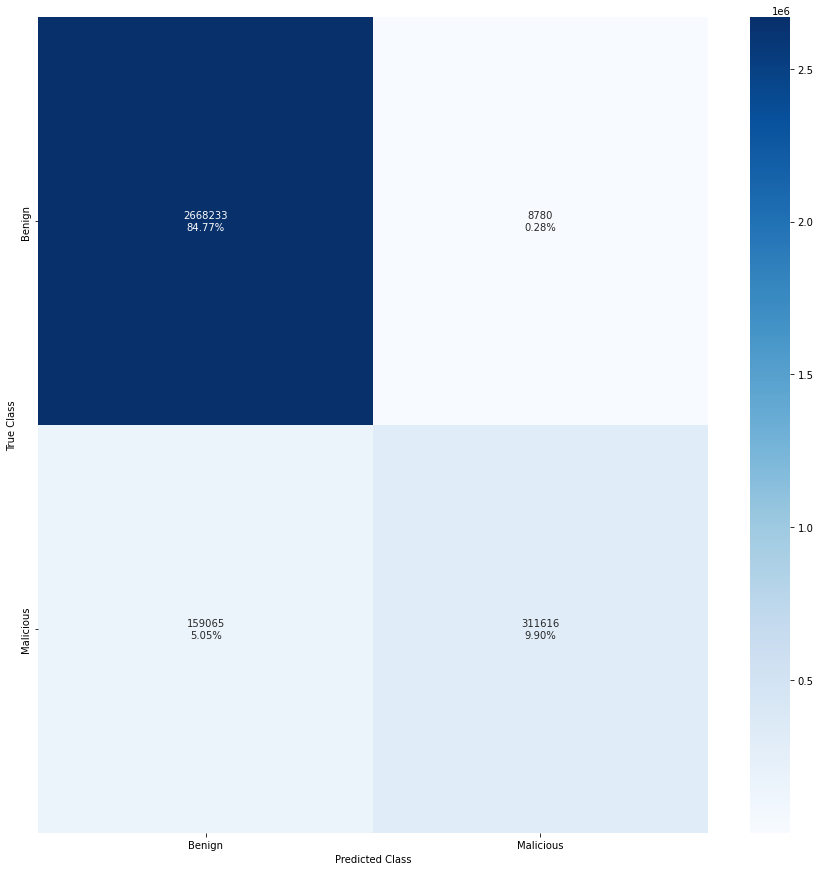

In [103]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
import tensorflow as tf 
#model = tf.keras.models.load_model('/'+model_name+'.h5')

y_pred = loaded_model.predict(X_test)

y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_cm, y_pred_cm) 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

label = ['Benign','Malicious']

plt.figure(figsize=(15,15))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
# plt.title('Confusion Matrix for'+ modelName+' model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
# plt.savefig('./'+modelName+'_CM.png')
plt.show()

In [104]:
from sklearn.metrics import classification_report



print(classification_report(y_test_cm, y_pred_cm, target_names= label,digits=5))
                            
loss, accuracy = loaded_model.evaluate(X_test,y_test, verbose = 1)
print("Test: accuracy = %f ; loss = %f " % (accuracy,loss))

              precision    recall  f1-score   support

      Benign    0.94374   0.99672   0.96951   2677013
   Malicious    0.97260   0.66205   0.78783    470681

    accuracy                        0.94668   3147694
   macro avg    0.95817   0.82939   0.87867   3147694
weighted avg    0.94805   0.94668   0.94234   3147694

98366/98366 [==============================] - 253s 3ms/step - loss: 0.1936 - accuracy: 0.9467
Test: accuracy = 0.946677 ; loss = 0.193588 
